# **Importing necessary libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score
import numpy as np
import os
import cv2
import zipfile
from PIL import Image
from shutil import copyfile  # Import the copyfile function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Unzipping Zip files**

In [2]:
# '''
# # Path to the zip file in Google Drive
# zip_file_path = '/content/drive/MyDrive/Fundus.zip'

# # Destination directory to extract the contents
# extracted_folder_path = '/content/drive/MyDrive/'

# # Create the destination directory if it doesn't exist
# os.makedirs(extracted_folder_path, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_folder_path)

# print("Extraction complete!")
# '''


# **Checking GPU availability**

In [3]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
    # Additional GPU configuration (optional)
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        # For TensorFlow 2.x
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        # For TensorFlow 1.x
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print('GPU is not available')


GPU is not available


# **Dataset Path**

In [4]:
# Define paths to our training, test, and validation data
train_path = 'D:\\Data\\fundus\\train\\Augmented Train\\'
test_path = 'D:\\Data\\fundus\\test\\Original\\'
validation_path = 'D:\\Data\\fundus\\validation\\Original\\'

# **Dataset Manipulation**

In [5]:
# Function to load images and labels in batches using PIL
def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            label = filename.split('_')[-1][0]  # Extract label (A, D, G, N) from filename

            img = Image.open(image_path).convert('RGB')  # Load image using PIL and convert to RGB format
            img = img.resize((224, 224))  # Resize image to (224, 224)
            img_array = np.array(img)  # Convert PIL image to NumPy array
            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)



# Load images and labels
train_images, train_labels = load_images_and_labels(train_path)
test_images, test_labels = load_images_and_labels(test_path)
validation_images, validation_labels = load_images_and_labels(validation_path)

In [6]:
# Define a mapping dictionary from string labels to numeric labels
label_map = {'A': 0, 'D': 1, 'G': 2, 'N': 3}

# Convert string labels to numeric labels
train_numeric_labels = np.array([label_map[label] for label in train_labels])
test_numeric_labels = np.array([label_map[label] for label in test_labels])
validation_numeric_labels = np.array([label_map[label] for label in validation_labels])


**Change the variations of DenseNet to check the results**

# **Pre-trained CNN for Feature Extraction**
* **DenseNet121**
* **DenseNet169**
* **DenseNet201**






In [7]:
# Define model architecture
def create_model(summary=True):
    new_input = Input(shape=(224, 224, 3))
    model = DenseNet169(weights='imagenet', include_top=False, input_tensor=new_input)
    flat1 = Flatten()(model.layers[-1].output)
    output = Dense(4, activation='softmax')(flat1)  # Assuming 4 classes
    model = tf.keras.Model(inputs=model.inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    if summary:
        print(model.summary())
    return model

In [8]:
# Create and compile the model
model = create_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# **Model Checkpint**

In [9]:
model_dir = 'D:\\Data\\fundus_DenseNet169'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,  # Save only the best model
                                                 monitor="val_accuracy",   # Monitor validation loss
                                                 mode="max",           # Save the model when validation loss is minimized
                                                 verbose=1)

# **Training Starts Here.....**

In [10]:
# Train the model
history = model.fit(
    x=train_images,
    y=train_numeric_labels,
    batch_size=16,
    epochs=10,
    validation_data=(validation_images, validation_numeric_labels),
    callbacks=[cp_callback]
)

Epoch 1/10
179/179 [==============================] - 70s 266ms/step - loss: 0.4336 - accuracy: 0.8592 - val_loss: 2.7830 - val_accuracy: 0.6333

Epoch 00001: val_accuracy improved from -inf to 0.63333, saving model to D:\Data\fundus_DenseNet169\cp.ckpt
Epoch 2/10
179/179 [==============================] - 40s 223ms/step - loss: 0.0564 - accuracy: 0.9800 - val_loss: 3.5997 - val_accuracy: 0.5667

Epoch 00002: val_accuracy did not improve from 0.63333
Epoch 3/10
179/179 [==============================] - 40s 223ms/step - loss: 0.0417 - accuracy: 0.9846 - val_loss: 1.3398 - val_accuracy: 0.7250

Epoch 00003: val_accuracy improved from 0.63333 to 0.72500, saving model to D:\Data\fundus_DenseNet169\cp.ckpt
Epoch 4/10
179/179 [==============================] - 41s 226ms/step - loss: 0.0489 - accuracy: 0.9846 - val_loss: 2.5598 - val_accuracy: 0.6417

Epoch 00004: val_accuracy did not improve from 0.72500
Epoch 5/10
179/179 [==============================] - 40s 225ms/step - loss: 0.1028 - a

# **SAVE history.....**

In [11]:
# Save the training history
initial_epoch = 0  # or the actual initial epoch of the first training session
saved_history = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'],
    # Add other metrics as needed
}
np.save("D:\\Data\\fundus_graphs\\Dense169_saved_history.npy", saved_history)

# **Loading Saved Model....**

In [10]:
# Load the latest checkpoint file
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint is not None:
    # Create a new model instance
    loaded_model = create_model(summary=True)

    # Load the previously saved weights and silence the warnings
    status = loaded_model.load_weights(latest_checkpoint)
    status.expect_partial()  # Ignore unrestored variables
else:
    print("No checkpoint file found in the specified directory.")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

# **Load the previous history**

In [5]:
# Load the previous history
previous_history = np.load("D:\Data\\fundus_graphs\\Dense169_saved_history.npy", allow_pickle=True).item()
initial_epoch = len(previous_history['loss'])
print(initial_epoch)

50


# **Again Train the loaded model.....**

In [17]:
loaded_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model
history = loaded_model.fit(
    initial_epoch=initial_epoch,
    x=train_images,
    y=train_numeric_labels,
    batch_size=24,
    epochs=100,
    validation_data=(test_images, test_numeric_labels), #(validation_images, validation_numeric_labels),
    callbacks=[cp_callback]
)

Epoch 51/100
119/119 [==============================] - 56s 331ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.8311 - val_accuracy: 0.8833

Epoch 00051: val_accuracy did not improve from 0.93333
Epoch 52/100
119/119 [==============================] - 38s 316ms/step - loss: 2.8891e-04 - accuracy: 1.0000 - val_loss: 0.7415 - val_accuracy: 0.9167

Epoch 00052: val_accuracy did not improve from 0.93333
Epoch 53/100
119/119 [==============================] - 38s 317ms/step - loss: 5.6195e-05 - accuracy: 1.0000 - val_loss: 0.7101 - val_accuracy: 0.9167

Epoch 00053: val_accuracy did not improve from 0.93333
Epoch 54/100
119/119 [==============================] - 38s 317ms/step - loss: 1.0991e-04 - accuracy: 1.0000 - val_loss: 0.7122 - val_accuracy: 0.9167

Epoch 00054: val_accuracy did not improve from 0.93333
Epoch 55/100
119/119 [==============================] - 38s 318ms/step - loss: 2.1772e-05 - accuracy: 1.0000 - val_loss: 0.7218 - val_accuracy: 0.9167

Epoch 00055: val_accurac

In [16]:
# Update and save the training history
previous_history['loss'].extend(history.history['loss'])
previous_history['accuracy'].extend(history.history['accuracy'])
previous_history['val_loss'].extend(history.history['val_loss'])
previous_history['val_accuracy'].extend(history.history['val_accuracy'])
# Repeat for other metrics as needed

np.save("C:\\Users\\Mukaffi\\Desktop\\CM\\Xai\\Dense169_saved_history.npy", previous_history)

In [17]:
import pandas as pd 
pd.DataFrame(previous_history).to_csv("D:\\Data\\Checkpoints_dense169Epoch.csv")

# **Accuracy and loss graph of training and validation**

In [20]:
#previous_history

# **There will be change in xticks and yticks as per model epochs**

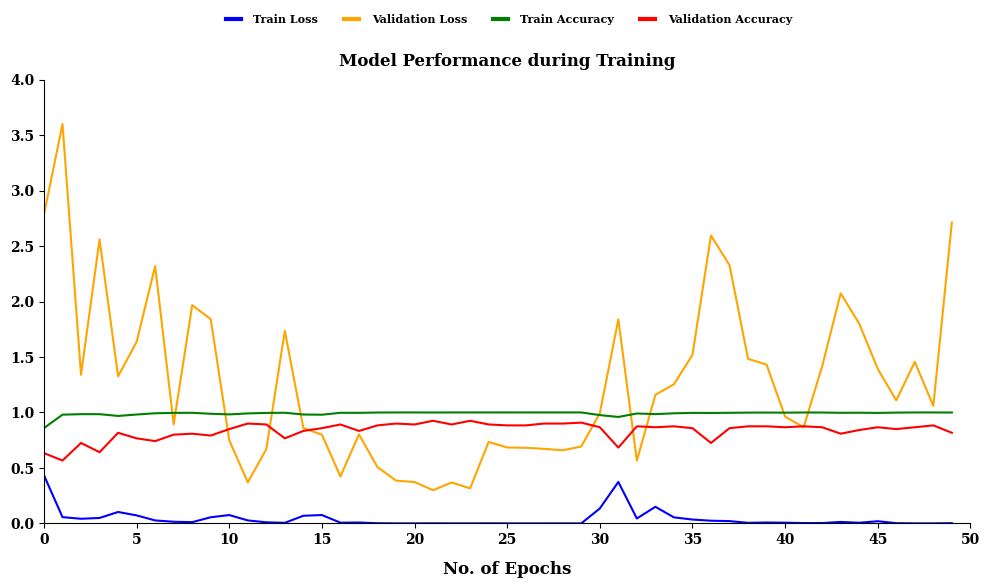

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

# Plot training & validation loss values
plt.figure(figsize=(10, 6))

# Plot Loss
train_loss, = plt.plot(previous_history['loss'], label='Train Loss', color='blue')
val_loss, = plt.plot(previous_history['val_loss'], label='Validation Loss', color='orange')
train_accuracy, = plt.plot(previous_history['accuracy'], label='Train Accuracy',  color='green')
val_accuracy, = plt.plot(previous_history['val_accuracy'], label='Validation Accuracy', color='red')
# Add a title with specified font properties
plt.title('Model Performance during Training', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12},pad=10)
# Set x-axis label with specified font properties
plt.xlabel('No. of Epochs', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

# Set x-axis ticks font properties
#plt.xticks(np.linspace(0, len(history.history['loss']), num=6), fontname='Serif', weight='bold')

plt.xticks(np.linspace(0, 50, num=11), fontname='Serif', weight='bold')


# Set y-axis ticks font properties
plt.yticks(np.linspace(0, 4, num=9), fontname='Serif', weight='bold')

# Set the x-axis and y-axis limits
#plt.xlim(0, len(history.history['loss']))

plt.xlim(0, 50)
plt.ylim(0, 4)

# Define custom legend lines with desired line properties
legend_lines = [
    Line2D([0], [0], color='blue', lw=3),          # Train Loss
    Line2D([0], [0], color='orange', lw=3),       # Validation Loss
    Line2D([0], [0], color='green', lw=3),        # Train Accuracy
    Line2D([0], [0], color='red', lw=3)           # Validation Accuracy
]

# Place legend outside the graph by adjusting bbox_to_anchor and specifying it to be outside the axes
plt.legend(legend_lines, ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'],
           loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=5,
           prop={'family': 'Serif', 'weight': 'bold', 'size': 8}, frameon=False,
           handler_map={Line2D: HandlerLine2D(numpoints=5)})

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('D:\\Data\\densenet169_accuracy_graph.pdf')  # Save as pdf format
plt.show()


# **Evaluating the model**

In [20]:
# Evaluate the model on the test dataset
loss, accuracy = loaded_model.evaluate(test_images, test_numeric_labels)

# Print the evaluation metrics (loss and accuracy)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


4/4 [==============================] - 10s 1s/step - loss: 1.0035 - accuracy: 0.9333
Test Loss: 1.0035202503204346
Test Accuracy: 0.9333333373069763


# **Prediction on Test Dataset**

In [21]:
# Make predictions on the test dataset
predictions = loaded_model.predict(test_images)

# Get predicted labels (convert from numeric to string labels using inverse mapping)
inverse_label_map = {v: k for k, v in label_map.items()}
predicted_labels = [inverse_label_map[np.argmax(pred)] for pred in predictions]
# Print test and predicted labels
for i in range(len(test_labels)):
    print(f"Test Label: {test_labels[i]}, Predicted Label: {predicted_labels[i]}")


Test Label: D, Predicted Label: D
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: D
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: A, Predicted Label: A
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: D
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G, Predicted Label: G
Test Label: G,

# **Classification Report**

In [22]:
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels,digits=4))


Classification Report:
              precision    recall  f1-score   support

           A     1.0000    0.8667    0.9286        30
           D     0.8824    1.0000    0.9375        30
           G     0.9032    0.9333    0.9180        30
           N     0.9655    0.9333    0.9492        30

    accuracy                         0.9333       120
   macro avg     0.9378    0.9333    0.9333       120
weighted avg     0.9378    0.9333    0.9333       120



# **Evaluation Metrics**

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score,roc_auc_score

# Assuming predicted_probs contains the probabilities for each class

predicted_probs = loaded_model.predict(test_images)
# Calculate Accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# Calculate Precision, Recall, F1 Score
precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision}")

recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall}")

f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")

# Calculate Jaccard Score
jaccard = jaccard_score(test_labels, predicted_labels, average='weighted')
print(f"Jaccard Score: {jaccard}")

logloss = log_loss(test_numeric_labels, predicted_probs)
print(f"Log Loss: {logloss}")

Accuracy: 0.9333333333333333
Precision: 0.9377739972518485
Recall: 0.9333333333333333
F1 Score: 0.933314189457389
Jaccard Score: 0.8751825656948996
Log Loss: 0.9080667112671971


# **ROC AUC Score**

In [25]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode string labels ('A', 'D', 'G', 'N') to numeric labels
numeric_test_labels = label_encoder.fit_transform(test_labels)

# Calculate ROC AUC score using One-vs-Rest (ovr) strategy
roc_auc_ovr = roc_auc_score(numeric_test_labels, predicted_probs, multi_class='ovr')
print(f"ROC AUC Score (One-vs-Rest): {roc_auc_ovr}")

# Calculate ROC AUC score using One-vs-One (ovo) strategy
roc_auc_ovo = roc_auc_score(numeric_test_labels, predicted_probs, multi_class='ovo')
print(f"ROC AUC Score (One-vs-One): {roc_auc_ovo}")


ROC AUC Score (One-vs-Rest): 0.9827777777777778
ROC AUC Score (One-vs-One): 0.9827777777777778


# **Confusion Matrix**

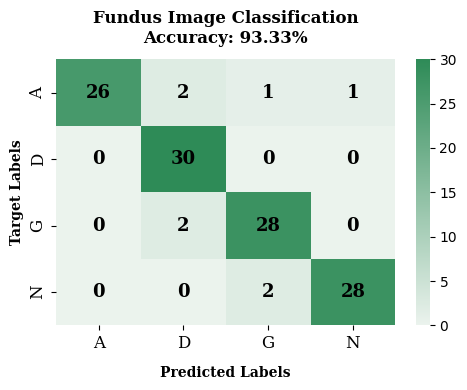

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(5, 4))
# Define the custom palette
custom_palette = sns.light_palette("seagreen", as_cmap=True)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=['A', 'D', 'G', 'N'], yticklabels=['A', 'D', 'G', 'N'],
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('Fundus Image Classification\nAccuracy: {:.2f}%'.format(accuracy_percentage),
                  fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('C:\\Users\\Mukaffi\\Desktop\\CM\\Xai\\DenseNet169(2)____confusion_matrix.pdf')  # Save as pdf format
plt.show()


# **No. 1 : Explainable AI (GradCAM)**

* Step 1: Prepare the Model (We've done it already)
* Step 2: Load and Preprocess an Image (We'll need an image to visualize the Grad-CAM heatmap)
* Step 3: Get the Class Activation Map (CAM) (We'll create a function to generate the Grad-CAM heatmap using the model we've built)

# **Function for displaying Original and GradCAM images**

In [19]:
# Function to save and display GradCAM
def save_and_display_gradcam(img_path, heatmap, alpha=0.6):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('C:\\Users\\Mukaffi\\Desktop\\CM\\Xai\\DenseNet169_gradcam.pdf')  # Save as pdf format
    plt.show()



# **GradCAM function**

 **Gradient Calculation:** Using these activations, GradCAM computes the gradients of the predicted class's score with respect to the feature maps. These gradients indicate the importance of each feature map in determining the final class prediction.

**Global Average Pooling (GAP):** GradCAM takes the gradients and performs Global Average Pooling (GAP) across the spatial dimensions of each feature map. This step generates a weight for each feature map, reflecting its relevance to the predicted class.

**Weighted Combination:** GradCAM computes a weighted combination of the feature maps based on their importance weights obtained from GAP. This combination highlights the regions in the feature maps that strongly influence the predicted class.

**Heatmap Generation:** The weighted combination produces a heatmap by overlaying these selected regions back onto the input image. The heatmap visually demonstrates which parts of the image are pivotal in the model's decision-making for the predicted class.

In [20]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



# **Visualization of Grad-Cam**

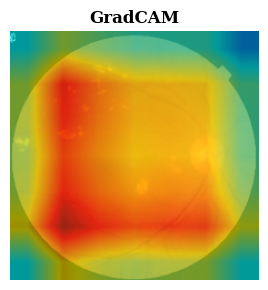

In [21]:
 # make a prediction and visualize grad-cam
def make_prediction_and_visualize_():
    img_path = 'D:\\Data\\fundus\\train\\Original\\131_A.png'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)


    last_conv_layer_name = 'conv5_block32_concat' #conv5_block32_2_conv

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam(img_path, heatmap)


make_prediction_and_visualize_()

# **No. 2 : Explainable AI (GradCAM++)**



* Step 1: Prepare the Model (We've done it already)
* Step 2: Load and Preprocess an Image (We'll need an image to visualize the Grad-CAM++ heatmap)
* Step 3: Get the Class Activation Map (CAM) (We'll create a function to generate the Grad-CAM++ heatmap using the model we've built)

# **Function for displaying Original and GradCAM++ images**

In [22]:
# Function to save and display ScoreCAM
def save_and_display_gradcam_plusplus(img_path, heatmap, alpha=0.6):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM++', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('C:\\Users\\Mukaffi\\Desktop\\CM\\Xai\\DenseNet169__gradcam_plusplus.pdf')  # Save as pdf format
    plt.show()



# **GradCAM++ function**

* **Gradient Computation:** Derive gradients between predicted class and conv layer's output, indicating feature map importance.
* **Positive and Negative Gradients:** Split gradients into positive (activating) and negative (inhibiting) parts, signifying influential and counteractive regions.
* **Weighting and Aggregation:** Calculate separate importance weights from positive and negative gradients, combining them to determine feature map significance.
* **Weighted Sum and Heatmap:** Blend positive and negative weights to generate a weighted sum, utilized for heatmap creation, pinpointing significant regions contributing to the predicted class.

In [23]:
# Function to generate GradCAM++ heatmap
def make_gradcam_plusplus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get gradients
    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads[0], axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Calculate guided gradients
    guided_grads = tf.cast(last_conv_layer_output > 0, 'float32') * grads[0]

    # Calculate importance weights
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Generate heatmap
    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()


# **Visualization of Grad-Cam++**

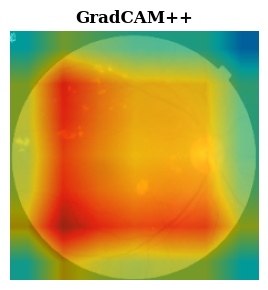

In [26]:
# Function to make a prediction and visualize GradCAM++
def make_prediction_and_visualize_gradcam_plusplus():
    img_path = 'D:\\Data\\fundus\\train\\Original\\131_A.png'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size
    rescaled_img = img / 255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block32_concat'

    # Generate GradCAM++ heatmap
    heatmap = make_gradcam_plusplus_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam_plusplus(img_path, heatmap)

make_prediction_and_visualize_gradcam_plusplus()

# **No. 3 : Explainable AI (ScoreCAM)**
* Step 1: Prepare the Model (We've done it already)
* Step 2: Load and Preprocess an Image (We'll need an image to visualize the Score-CAM heatmap)
* Step 3: Get the Class Activation Map (CAM) (We'll create a function to generate the Score-CAM heatmap using the model we've built)


In [27]:
# Function to save and display ScoreCAM
def save_and_display_scorecam(img_path, heatmap, alpha=0.6):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('ScoreCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('C:\\Users\\Mukaffi\\Desktop\\CM\\Xai\\DenseNet169__scorecam.pdf')  # Save as pdf format
    plt.show()



# **ScoreCAM function**
* **Gradient Computation:** Score-CAM calculates the gradients of the predicted class score with respect to the output feature maps, just like Grad-CAM. These gradients provide information about the importance of each feature map in the predicted class's activation.
* **Guided Gradients:** Instead of considering positive and negative gradients separately, Score-CAM utilizes guided gradients to focus only on positive gradients, i.e., gradients that have a positive influence on the predicted class. This step enhances the saliency of the significant regions.
* **Global Average Pooling (GAP):** Score-CAM performs Global Average Pooling (GAP) across the spatial dimensions of the guided gradients to generate importance weights for each feature map, indicating their relevance to the predicted class.
* **Score-weighted Activation Map:** The technique computes a score-weighted activation map by multiplying the weights obtained from GAP with the feature maps and summing across channels. This highlights the regions in the feature maps that contribute the most to the predicted class, emphasizing the most discriminative areas in the input image.

In [28]:
import tensorflow as tf

def make_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)
    guided_grads = tf.cast(grads[0] > 0, 'float32') * grads[0]

    # GAP (Global Average Pooling) along the spatial dimensions
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Calculate the score-weighted activation map
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of ScoreCam**

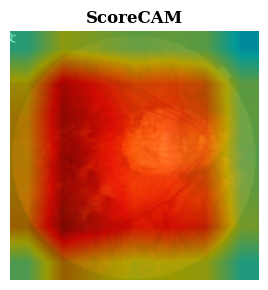

In [29]:
# make a prediction and visualize ScoreCAM
def make_prediction_and_visualize_scorecam():
    img_path = 'D:\\Data\\fundus\\train\\Original\\67_D.png'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block32_concat'

    # Generate class activation heatmap
    heatmap = make_scorecam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_scorecam(img_path, heatmap)

make_prediction_and_visualize_scorecam()


# **No. 4 : Explainable AI (Faster Score-CAM)**
* step 1: Prepare the Model (We've done it already)
* Step 2: Load and Preprocess an Image (We'll need an image to visualize the Faster Score-CAM heatmap)
* Step 3: Get the Class Activation Map (CAM) (We'll create a function to generate the Faster Score-CAM heatmap using the model we've built)


# **Function for displaying Original and Faster ScoreCAM images**

In [30]:
# Function to save and display Faster ScoreCAM
def save_and_display_faster_scorecam(img_path, heatmap, alpha=0.6):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Faster ScoreCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('C:\\Users\\Mukaffi\\Desktop\\CM\\Xai\\DenseNet169__faster_scorecam.pdf')  # Save as pdf format
    plt.show()



# **Faster ScoreCAM function**

* **Gradient Calculation:** Using a GradientTape, it computes the gradients of the predicted class output with respect to the output feature map of the specified last convolutional layer.

* **Global Average Pooling (GAP):** The gradients obtained are subjected to Global Average Pooling (GAP) along the spatial dimensions, resulting in weights representing the importance of each feature map in the predicted class's activation.

* **Weighted Sum Calculation:** Reshaping the obtained weights and the convolutional output, the function performs matrix multiplication between them, efficiently obtaining a score-weighted activation map that highlights significant regions related to the predicted class.

* **Normalization and ReLU:** The resulting score-weighted activation map is normalized and subjected to ReLU (Rectified Linear Unit) activation, ensuring non-negativity and scaling to highlight the most influential regions.

In [31]:
def faster_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradient of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Reshape conv_output to match the dimensions for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map efficiently
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of faster ScoreCam**

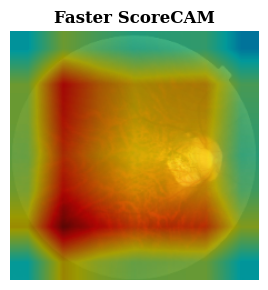

In [32]:
# make a prediction and visualize Faster ScoreCAM
def make_prediction_and_visualize_faster_scorecam():
    img_path = 'D:\\Our Future works\\fundus\\train\\Original\\144_G.png'#'D:\\Data\\fundus\\train\\Original/390_G.png'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block32_concat'

    # Generate class activation heatmap
    heatmap = faster_scorecam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_faster_scorecam(img_path, heatmap)

make_prediction_and_visualize_faster_scorecam()


# **No. 5 : Explainable AI (LayerCAM)**

* Step 1: Prepare the Model (We've done it already)
* Step 2: Load and Preprocess an Image (We'll need an image to visualize the LayerCAM heatmap)
* Step 3: Get the Class Activation Map (CAM) (We'll create a function to generate the LayerCAM heatmap using the model we've built)

# **Function for displaying Original and LayerCAM images**

In [33]:
# Function to save and display layercam
def save_and_display_layercam(img_path, heatmap, alpha=0.6):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('LayerCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('C:\\Users\\Mukaffi\\Desktop\\CM\\Xai\\DenseNet169__layercam.pdf')  # Save as pdf format
    plt.show()



# **LayerCAM function**

* **Gradient Calculation:** Utilize a gradient tape to compute gradients of the predicted class score with respect to the output feature maps obtained from the chosen layer.

* **Global Average Pooling (GAP):** Perform Global Average Pooling across the spatial dimensions of the gradients to generate importance weights for each feature map.

* **Weight Reshaping:** Reshape the obtained weights to fit the required dimensions for subsequent matrix multiplication.

* **Activation Map Computation:** Compute a score-weighted activation map by performing a matrix multiplication between the reshaped weights and the output feature maps from the chosen layer.

* **Activation Map Adjustment:** Apply Rectified Linear Unit (ReLU) to ensure non-negativity in the heatmap.

* **Normalization:** Normalize the heatmap to ensure that the values fall within a certain range, often between 0 and 1, which aids in visualization.

In [34]:
import tensorflow as tf

def generate_layercam_heatmap(img_array, model, last_conv_layer_name, target_class_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if target_class_index is None:
            target_class_index = tf.argmax(preds[0])
        class_output = preds[:, target_class_index]
        conv_output = last_conv_layer_output[0]

    # Calculate gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Expand dimensions of conv_output for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map (LayerCAM)
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


# **Visualization of LayerCAM**

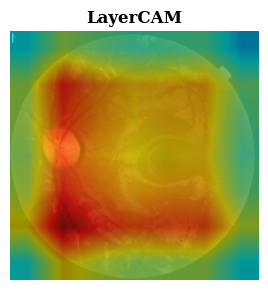

In [35]:
# make a prediction and visualize layercam
def make_prediction_and_visualize_layercam():
    img_path = 'D:\\Our Future works\\fundus\\train\\Original\\167_N.png'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))#IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block32_concat'

    # Generate class activation heatmap
    heatmap = generate_layercam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_layercam(img_path, heatmap)


make_prediction_and_visualize_layercam()